## Imports

In [1]:
!pip install Box2D

     |████████████████████████████████| 1.3MB 6.6MB/s 


In [1]:
# env
import gym
from gym.envs.box2d.lunar_lander import heuristic

# utils
import imageio
from IPython.display import Image, HTML, clear_output
import logging
import matplotlib.pyplot as plt
import numpy as np

# model
import tensorflow as tf
from tensorflow.keras import backend as K

saveImgs = False

%matplotlib inline 

## Get LunarLander env

In [2]:
env = gym.make('LunarLander-v2')
env._max_episode_steps = 250
gym.logger.setLevel(logging.ERROR)

## Useful functions

In [9]:
def run_episodes(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        if hasattr(policy, 'model'):
            action = policy.decide(observation)
        else:
            action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames

## Heuristic policy test

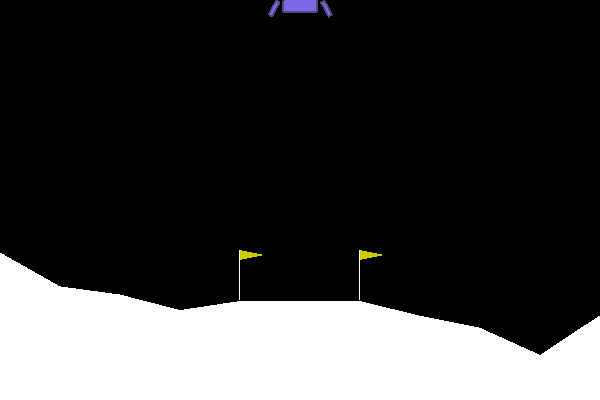

In [4]:
def heuristic_policy(env, observation):
    return heuristic(env.unwrapped, observation)

episodes = run_episodes(env, heuristic_policy)
if saveImgs:
    imageio.mimsave('imgs/heuristic_policy.gif', episodes, fps=45)
Image("imgs/heuristic_policy.gif")

## Random policy test

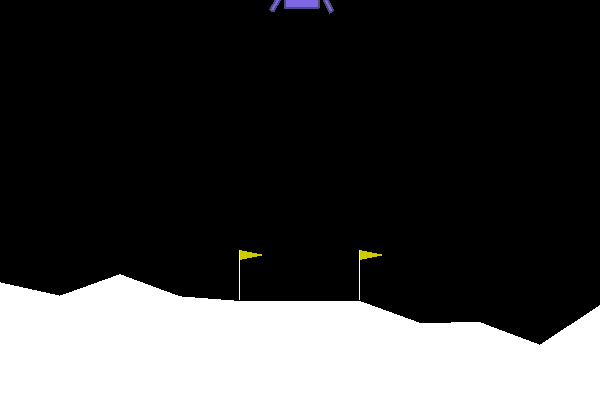

In [5]:
def random_policy(env, observation):
    return env.action_space.sample()
episodes = run_episodes(env, random_policy)
if saveImgs:
    imageio.mimsave('imgs/random_policy.gif', episodes, fps=45)
Image("imgs/random_policy.gif")

## Training loop

In [6]:
def training(agent, env, number_of_episodes=3000,
             saveEpisodeInterval = 3001, printRewardInterval = 20):

    rewards_per_episode = []
    frames_per_episode = []

    for episode_idx in range(number_of_episodes):

        # print previous episode results at wanted interval
        if (episode_idx+1) % printRewardInterval == 0:
            clear_output()
            plt.xlim(0, number_of_episodes)
            plt.plot(rewards_per_episode)
            plt.pause(0.0001)
            print(f"Episode n°{episode_idx}: {sum_rewards} rewards")
    
        # reset episode var
        frames = None
        state = env.reset()
        sum_rewards = 0

        # save frames at wanted interval
        if (episode_idx+1) % saveEpisodeInterval == 0:
            frames = []

        while True:

            # save frames at wanted interval
            if frames is not None:
                frames.append(env.render(mode='rgb_array'))

            # Take action
            action = agent.decide(state)
            next_state, reward, done, info = env.step(action)
            sum_rewards += reward

            # Store information for training
            agent.observe(state, action, reward)

            # Train agent with observed episode
            if done:
                rewards_per_episode.append(sum_rewards)

                # save frames at wanted interval
                if frames is not None:
                    frames_per_episode.append(frames)

                # train agent
                agent.train()
                break

            state = next_state
            
    return frames_per_episode, agent

In [7]:
class Agent(object):
    
    def __init__(self, n_obs, n_act, policy_learning_rate,
                 discount, entropy_cost = 0, max_ent_cost = 0):

        # agent attributes
        self.n_obs = n_obs  
        self.n_act = n_act
        self.gamma = discount

        # parameters
        self.policy_learning_rate = policy_learning_rate
        self.entropy_cost = entropy_cost
        self.max_ent_cost = max_ent_cost

        # observations
        self.reset_observation_lists()

        # build network
        self.model = tf.keras.models.Sequential([
               # take as input the observations
               tf.keras.layers.Dense(16, input_dim=self.n_obs,
                                     activation="relu"),
               tf.keras.layers.Dense(16, activation="relu"),
               tf.keras.layers.Dense(16, activation="relu"),
               # output a policy distribution
               tf.keras.layers.Dense(self.n_act, activation='softmax',
                                     activity_regularizer=self.entropy)
        ])
        
        opt = tf.keras.optimizers.Adam(lr=self.policy_learning_rate)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy')

    def observe(self, state, action, reward):
        """
        Save state, action and reward to agent memory

        Args:
          - (object) environment-specific object representing the observation
          - (float) action that the agent did
          - (float) reward that the agent got
        """
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
        
    def decide(self, state):
        """ 
        Get prediction from model with the observed state
        Choose an action from the output distribution

        Args:
            - (object) environment-specific object representing the observation
        
        Return:
            - (int) action to take
        """
        
        output = self.model.predict(state.reshape(-1, self.n_obs))
        choice = np.random.choice(self.n_act, p=output.reshape(-1))
        self.probability_action.append(output.reshape(-1)[choice])
        return choice

    def train(self):
        """ Train model with discounted reward and reset observations lists """
    
        discounted_reward = self.get_discounted_reward()
        actions_one_hot_encoding = np.array(
            tf.keras.utils.to_categorical(self.episode_actions, self.n_act))
        state = np.array(self.episode_observations)

        history = self.model.train_on_batch(state.reshape(-1, self.n_obs),
                                            actions_one_hot_encoding,
                                            sample_weight=discounted_reward)
        self.reset_observation_lists()

    def reset_observation_lists(self):
        self.episode_observations = []
        self.episode_actions = []
        self.episode_rewards = []
        self.probability_action = []

    def get_discounted_reward(self):
        """ Return discounted episode returns at each step in the episode """
        rewards = np.array(self.episode_rewards)
        discounted_rewards = np.zeros_like(rewards)
        sum = 0

        for t in reversed(range(0, len(rewards))):
            sum = sum * self.gamma + rewards[t]
            discounted_rewards[t] = sum

        return discounted_rewards - \
            np.log(self.probability_action)*self.max_ent_cost

    def entropy(self, input_data):
        return K.sum(K.log(input_data+1e-12)*input_data)*self.entropy_cost

    def load(self, path):
        """ Method to load agent that was already trained """
        self.model = tf.keras.models.load_model(path)


In [ ]:
agent = Agent(n_obs = env.observation_space.shape[0],
              n_act = env.action_space.n,
              policy_learning_rate = 0.002, 
              discount=0.99, entropy_cost = 0, max_ent_cost = 0)

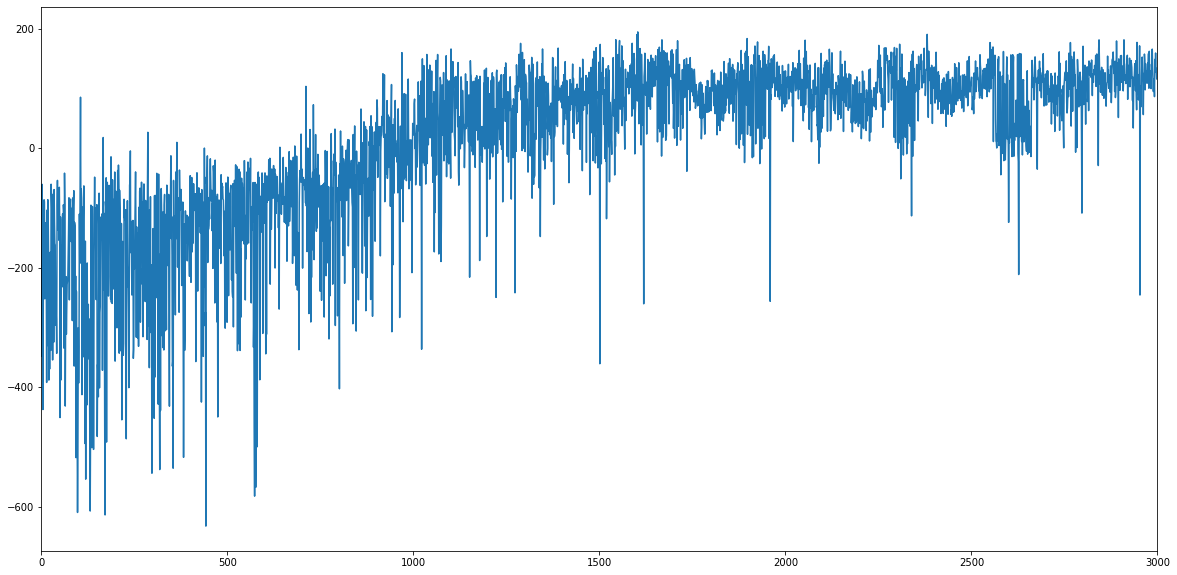

Episode n°2999: 116.45256524751579 rewards


In [7]:
plt.rcParams["figure.figsize"] = (20, 10)

episodes, agent = training(agent, env)

In [8]:
agent.model.save("rl_agent_3kepisodes")

INFO:tensorflow:Assets written to: rl_agent_3kepisodes/assets


## Final model after 3k episodes

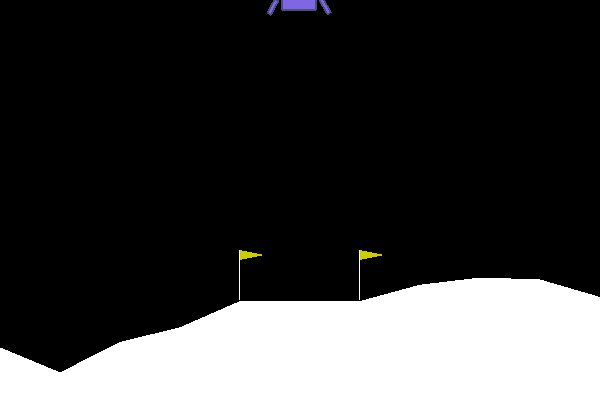

In [12]:
agent = Agent(n_obs = env.observation_space.shape[0],
              n_act = env.action_space.n,
              policy_learning_rate = 0.002, 
              discount=0.99, entropy_cost = 0, max_ent_cost = 0)
agent.load("rl_agent_3kepisodes")

episodes = run_episodes(env, agent)
if saveImgs:
    imageio.mimsave('imgs/agent_3k_episodes.gif', episodes, fps=45)
Image("imgs/agent_3k_episodes.gif")